# Tutorial 4: Compare the predicted sample-cfRNA between the disease group and the normal group

CellFreeGMF employs a single-cell reference dataset to computationally association matrices that quantify relationships between pathological/healthy samples and specific cell types

In [1]:
rm(list = ls())

print(R.home())
print(.libPaths())

[1] "/home/zhangwenxiang/anaconda3/envs/CellFreeGMF/lib/R"
[1] "/home/zhangwenxiang/anaconda3/envs/CellFreeGMF/lib/R/library"


## Preparation

In [2]:
library(reticulate)
library(Seurat)
library(dplyr)
library(future)
library(ggplot2)
library(dplyr)
library(scales)
library(ggpubr)

Attaching SeuratObject

Warning message:
“程辑包‘dplyr’是用R版本4.2.3 来建造的”

载入程辑包：‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“程辑包‘scales’是用R版本4.2.3 来建造的”


Setting python environment

In [3]:
use_python("/home/zhangwenxiang/anaconda3/envs/CellFreeGMF/bin/python", required = TRUE)

py_config()

python:         /home/zhangwenxiang/anaconda3/envs/CellFreeGMF/bin/python
libpython:      /home/zhangwenxiang/anaconda3/envs/CellFreeGMF/lib/libpython3.10.so
pythonhome:     /home/zhangwenxiang/anaconda3/envs/CellFreeGMF:/home/zhangwenxiang/anaconda3/envs/CellFreeGMF
version:        3.10.16 | packaged by conda-forge | (main, Apr  8 2025, 20:53:32) [GCC 13.3.0]
numpy:          /home/zhangwenxiang/anaconda3/envs/CellFreeGMF/lib/python3.10/site-packages/numpy
numpy_version:  2.2.6

NOTE: Python version was forced by use_python() function

## Hyperparameter Configuration

In [4]:
setwd('/home/zhangwenxiang/workspace/python/cfRNA/v16')
disease_name = 'PDAC'

## Load predicted data

In [5]:
np <- import("numpy")

Decon_sampletype_disease_cfRNAtype_Target_gene <- np$load(paste("./save_data/", disease_name, "/Decon_sampletype_disease_cfRNAtype_Target_gene.npz", sep = ""), allow_pickle = TRUE)
Decon_sampletype_normal_cfRNAtype_Target_gene <- np$load(paste("./save_data/", disease_name, "/Decon_sampletype_normal_cfRNAtype_Target_gene.npz", sep = ""), allow_pickle = TRUE)

Normal_Target_decon_Result_sample_cfRNA <- py_to_r(Decon_sampletype_normal_cfRNAtype_Target_gene$f['Result_sample_cfRNA'])
Normal_Target_decon_Result_sample_cell <- py_to_r(Decon_sampletype_normal_cfRNAtype_Target_gene$f['Result_sample_cell'])
Normal_Target_decon_Result_cfRNA_cell <- py_to_r(Decon_sampletype_normal_cfRNAtype_Target_gene$f['Result_cfRNA_cell'])
Normal_Target_decon_sample_name <- py_to_r(Decon_sampletype_normal_cfRNAtype_Target_gene$f['sample_name'])
Normal_Target_decon_cfRNA_name <- py_to_r(Decon_sampletype_normal_cfRNAtype_Target_gene$f['cfRNA_name'])
Normal_Target_decon_cell_name <- py_to_r(Decon_sampletype_normal_cfRNAtype_Target_gene$f['cell_name_cell_ontology_class'])
Normal_Target_decon_cell_id <- py_to_r(Decon_sampletype_normal_cfRNAtype_Target_gene$f['cell_id'])
Normal_Target_cell_meta <- data.frame(cell_name = Normal_Target_decon_cell_name,
                                      cell_id = Normal_Target_decon_cell_id)

Disease_Target_decon_Result_sample_cfRNA <- py_to_r(Decon_sampletype_disease_cfRNAtype_Target_gene$f['Result_sample_cfRNA'])
Disease_Target_decon_Result_sample_cell <- py_to_r(Decon_sampletype_disease_cfRNAtype_Target_gene$f['Result_sample_cell'])
Disease_Target_decon_Result_cfRNA_cell <- py_to_r(Decon_sampletype_disease_cfRNAtype_Target_gene$f['Result_cfRNA_cell'])
Disease_Target_decon_sample_name <- py_to_r(Decon_sampletype_disease_cfRNAtype_Target_gene$f['sample_name'])
Disease_Target_decon_cfRNA_name <- py_to_r(Decon_sampletype_disease_cfRNAtype_Target_gene$f['cfRNA_name'])
Disease_Target_decon_cell_name <- py_to_r(Decon_sampletype_disease_cfRNAtype_Target_gene$f['cell_name_cell_ontology_class'])
Disease_Target_decon_cell_id <- py_to_r(Decon_sampletype_disease_cfRNAtype_Target_gene$f['cell_id'])
Disease_Target_cell_meta <- data.frame(cell_name = Disease_Target_decon_cell_name,
                                      cell_id = Disease_Target_decon_cell_id)

Extracting sample-cell matrix

In [6]:
combined_mat <- data.frame(rbind(Normal_Target_decon_Result_sample_cell, 
                                 Disease_Target_decon_Result_sample_cell))
rownames(combined_mat) <- c(paste(Normal_Target_decon_sample_name,'_0', sep=""), 
                            paste(Disease_Target_decon_sample_name, '_1', sep = ""))
colnames(combined_mat) <- c(Disease_Target_decon_cell_id)

sample_cell <- as.matrix(combined_mat) %*% as.matrix(table(Normal_Target_decon_cell_id, Disease_Target_decon_cell_name))
disease_sample_cell <- sample_cell[1:length(Normal_Target_decon_sample_name),]
normal_sample_cell <- sample_cell[(length(Normal_Target_decon_sample_name) + 1):length(Disease_Target_decon_sample_name), ]

Calculate p value

In [7]:
label <- c(rep("Normal", length(Normal_Target_decon_sample_name)),
           rep("Tumor", length(Disease_Target_decon_sample_name)))

p_values_wilcox <- sapply(1:ncol(sample_cell), function(i) {
  wilcox.test(sample_cell[, i] ~ label)$p.value
})
names(p_values_wilcox) <- colnames(sample_cell)
p_values_wilcox <- p_values_wilcox[p_values_wilcox < 0.05]
p_values_wilcox

endothelial cell             myeloid cell   pancreatic acinar cell 
             0.003418754              0.007552919              0.004049733 
   pancreatic alpha cell   pancreatic ductal cell pancreatic stellate cell 
             0.014451215              0.003377305              0.041521423 
                  t cell 
             0.006044487

The analysis identified eight cell types with significant differences in sample–cell associations between PDAC and healthy conditions, notably including pancreas-associated cells, myeloid cells, and T cells

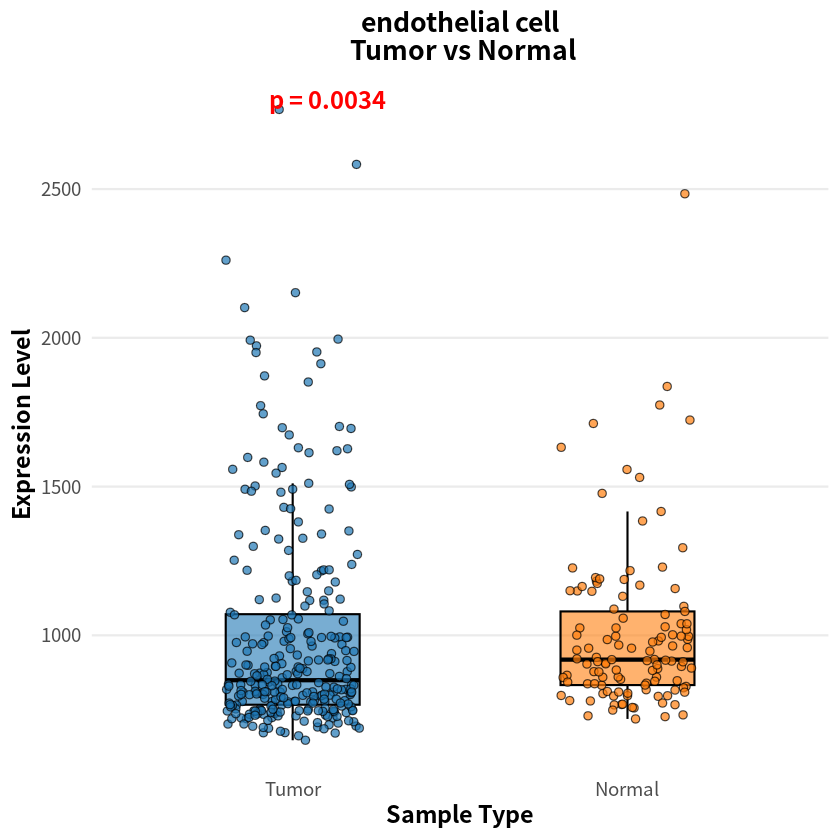

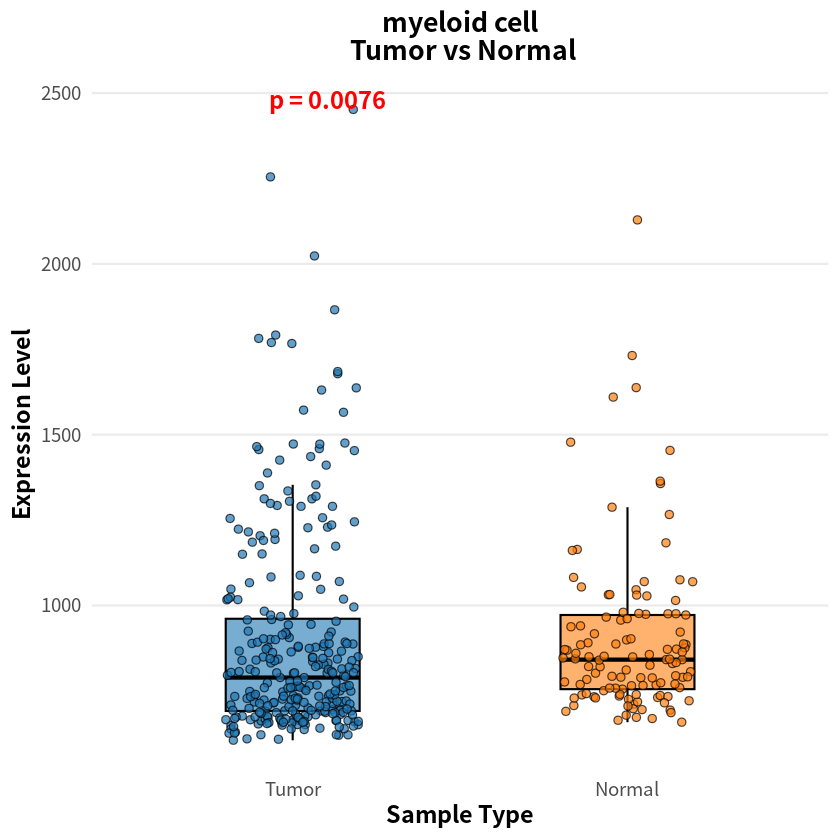

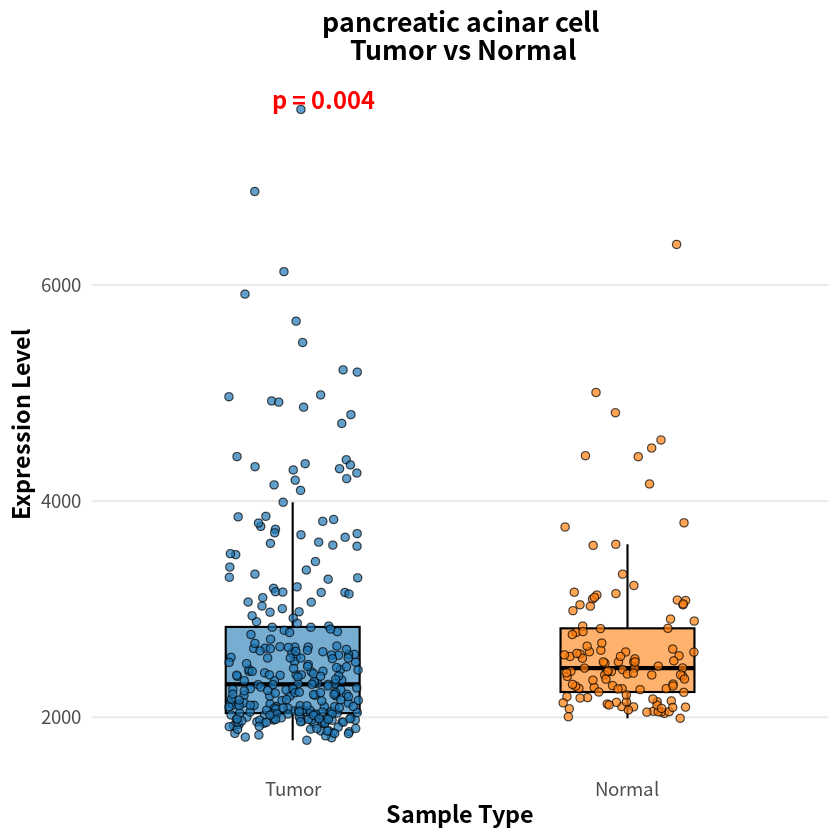

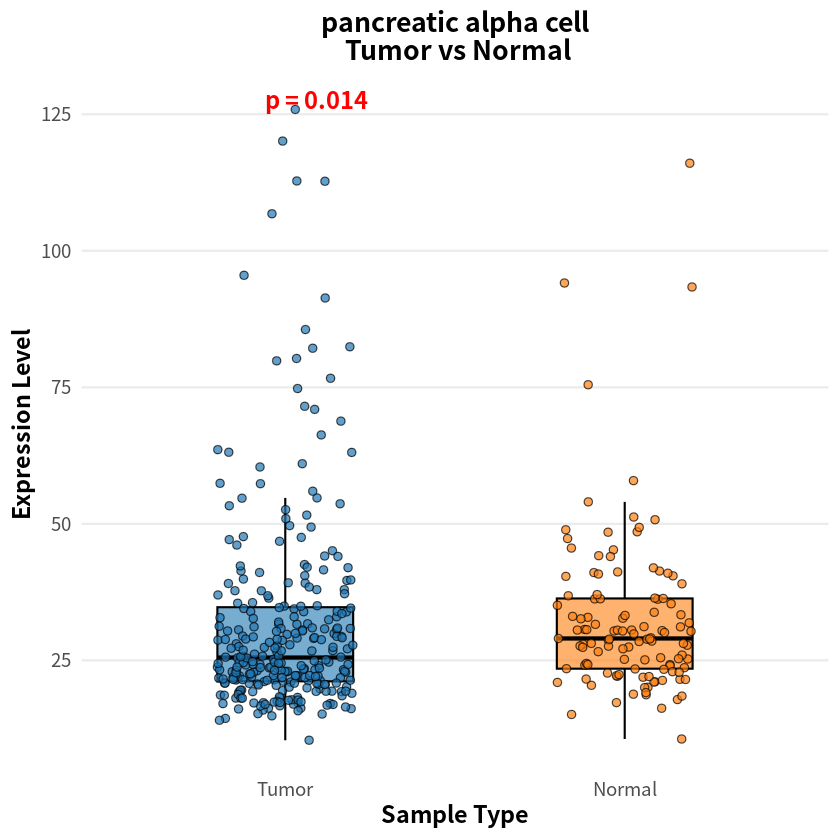

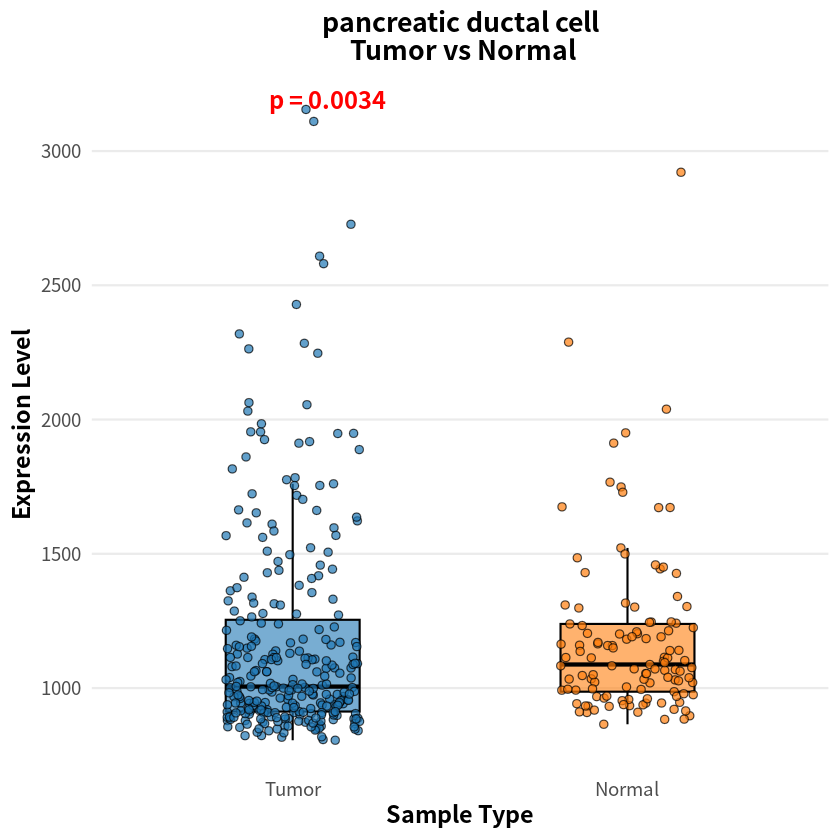

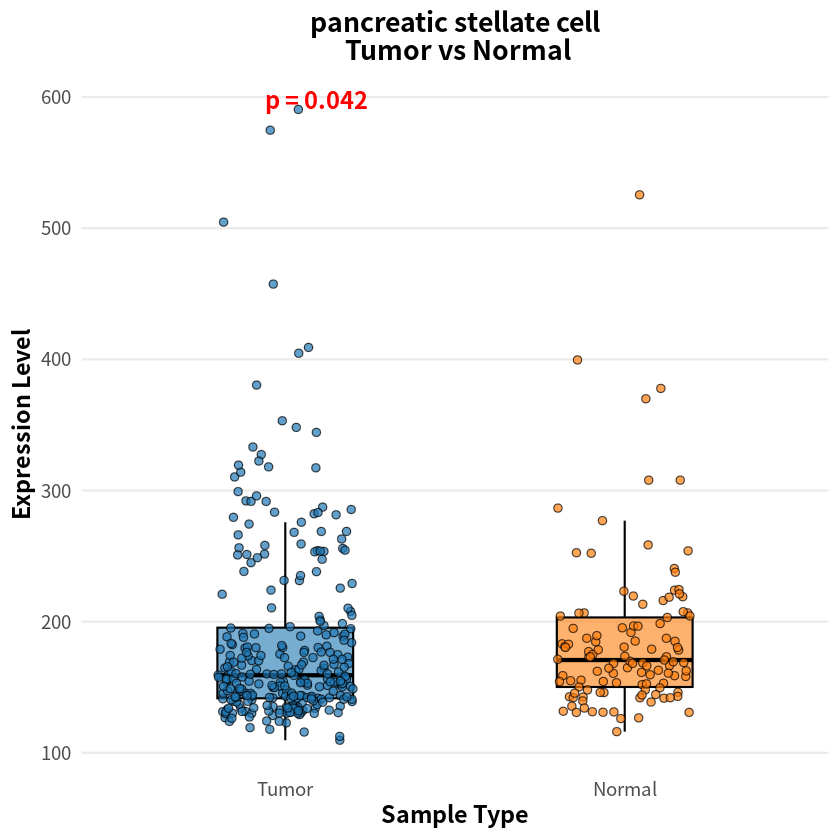

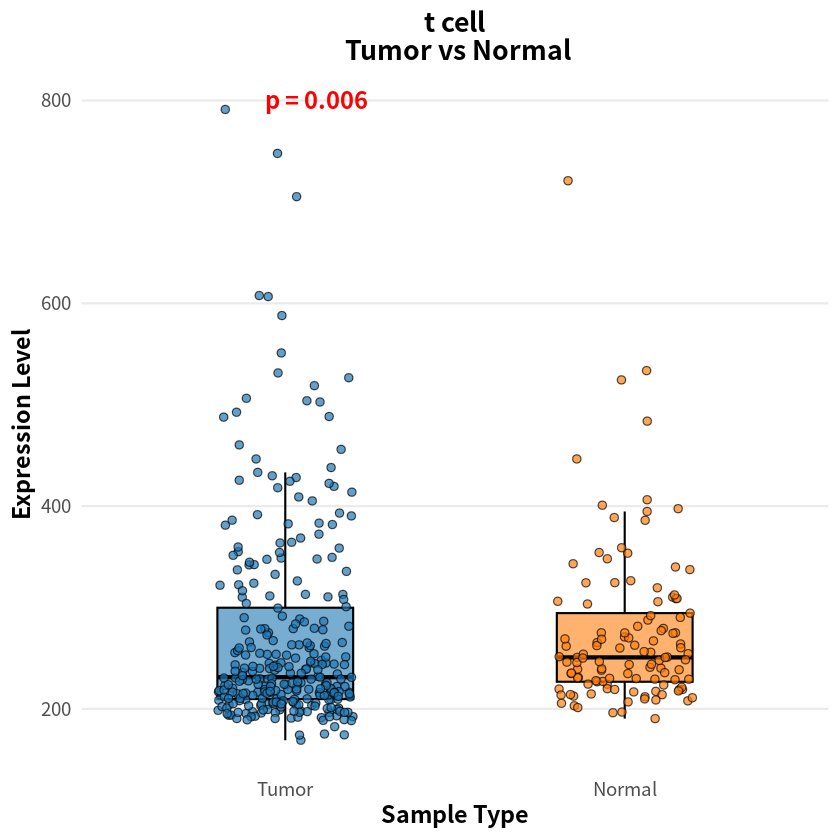

In [8]:
for(cell_name in names(p_values_wilcox)){
  
  expr_df <- as.data.frame(sample_cell[, cell_name])
  colnames(expr_df) <- 'Cell1'
  
  cell1_df <- data.frame(
    Expression = expr_df$Cell1,
    SampleType = factor(label, levels = c("Tumor", "Normal"))
  )
  
  p <- ggplot(cell1_df, aes(x = SampleType, y = Expression, fill = SampleType)) + 
    geom_boxplot(width = 0.4, alpha = 0.6, outlier.shape = NA, color = "black", lwd = 0.6) +
    geom_jitter(width = 0.2, size = 2, alpha = 0.7, shape = 21, color = "black") +
    stat_compare_means(
      method = "wilcox.test",
      label = "p.format",
      label.y.npc = "top",
      size = 5,
      fontface = "bold",
      color = "red"
    ) +
    scale_fill_manual(values = c("Tumor" = "#1f77b4", "Normal" = "#ff7f0e")) +
    theme_minimal(base_size = 14) +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
      axis.title = element_text(face = "bold"),
      legend.position = "none",
      panel.grid.major.x = element_blank(),
      panel.grid.minor = element_blank()
    ) +
    labs(
      title = paste(cell_name, "\n Tumor vs Normal", sep = ""),
      x = "Sample Type",
      y = "Expression Level"
    )
  print(p)
}